In [5]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D ,Input , AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import time

# Hyperparameters
IMAGE_SIZE = (150,150)
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 1e-3


def image_gen_w_aug(train_parent_directory, validate_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        zoom_range=0.2,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)

    train_generator = train_datagen.flow_from_directory(
        train_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        validate_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        test_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

def model_output():
    model = Sequential()

    Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D(2, 2))

    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))

    return model

train_dir = os.path.join('./datasets/train')
test_dir = os.path.join('./datasets/test')
val_dir = os.path.join('./datasets/validation')

train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir, test_dir)

model = model_output()
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Learning rate reduction
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-7)

# Start time
start_time = time.time()

model.summary()

with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        verbose=1,
        validation_data=validation_generator,
        callbacks=[lr_scheduler]
    )


# end Time
end_time = time.time()
# duration 
duration = end_time - start_time

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

tf.keras.models.save_model(model,'my_model.h5')



Found 2396 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 299 images belonging to 3 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 830ms/step - accuracy: 0.4501 - loss: 1.0791 - val_accuracy: 0.6500 - val_loss: 0.8643 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - accuracy: 0.7531 - loss: 0.6719 - val_accuracy: 0.8167 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 777ms/step - accuracy: 0.8064 - loss: 0.5349 - val_accuracy: 0.8233 - val_loss: 0.5003 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - accuracy: 0.8142 - loss: 0.5203 - val_accuracy: 0.8433 - val_loss: 0.3823 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 769ms/step - accuracy: 0.8156 - loss: 0.4683 - val_accuracy: 0.8433 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 752ms/step - accuracy: 0.8519 - loss: 0.4343 - val_accuracy: 0.8700 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - accuracy: 0.8486 - l

Changed pooling layers

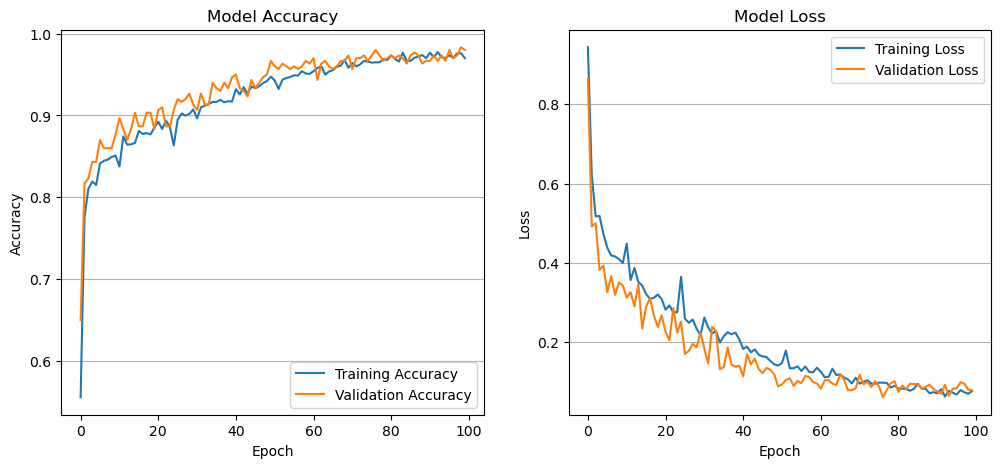

Total time taken to train the model: 106 minutes and 24 seconds

Final Training Accuracy: 0.9699
Final Validation Accuracy: 0.9800

Final Training Loss: 0.0771
Final Validation Loss: 0.0789

Test Accuracy: 96.66%
Test Loss: 0.1365


In [6]:

# Plot training and validation accuracy
plt.figure(figsize=(12,5))       
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.grid(axis='y')
plt.legend()

# Plot training and validation loss
plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Model Loss")
plt.legend()
plt.grid(axis='y')
plt.show()

# Convert duration to minutes and seconds
duration_min, duration_sec = divmod(duration, 60)
print(f'Total time taken to train the model: {int(duration_min)} minutes and {int(duration_sec)} seconds')
print()
# Print out the final accuracy values
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print()
# Print out the final loss values
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')